<a href="https://colab.research.google.com/github/k4zuy/Rep-Baal-Progress/blob/main/Augmented/baal_testground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ColinS97/BaaL_Experiments.git

Cloning into 'BaaL_Experiments'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 148 (delta 88), reused 108 (delta 48), pack-reused 0
Receiving objects: 100% (148/148), 170.61 KiB | 14.22 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [2]:
cd BaaL_Experiments

/content/BaaL_Experiments


In [3]:
!pip install baal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 5.6 MB/s 
     |████████████████████████████████| 4.1 MB 26.3 MB/s 
     |████████████████████████████████| 11.2 MB 60.4 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 965 kB 58.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Required for Nvidia RTX 3060

In [ ]:
#python -m pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Required for Colab

In [21]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 29.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
baal 1.6.0 requires matplotlib<4.0.0,>=3.4.3, but you have matplotlib 3.1.3 which is incompatible.


Imports

In [5]:
import argparse
import random
import csv
from copy import deepcopy
from time import time
import datetime
from dataclasses import dataclass
import numpy as np
import PIL
import matplotlib.pyplot as plt

import torch
import torch.backends
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision.models import vgg16
from torchvision.transforms import transforms
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.bayesian.dropout import patch_module
from baal import ModelWrapper
from baal.utils.metrics import Accuracy
from baal.active.heuristics import BALD
from baal.active.dataset import ActiveLearningDataset

import aug_lib

from baal_extended.ExtendedActiveLearningDataset import ExtendedActiveLearningDataset

In [6]:
@dataclass
class ExperimentConfig:
    epoch: int = 2
    batch_size: int = 32
    initial_pool: int = 1000
    query_size: int = 100
    lr: float = 0.001
    heuristic: str = 'bald'
    iterations: int = 40
    training_duration: int = 10

In [154]:
def get_datasets(initial_pool, n_augmentations):
    transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    aug_transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            aug_lib.TrivialAugment(),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    test_transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    # Note: We use the test set here as an example. You should make your own validation set.
    train_ds = datasets.CIFAR10(
        ".", train=True, transform=transform, target_transform=None, download=True
    )

    aug_train_ds = datasets.CIFAR10(
        ".", train=True, transform=aug_transform, target_transform=None, download=True
    )
    test_set = datasets.CIFAR10(
        ".", train=False, transform=test_transform, target_transform=None, download=True
    )
    eald_set = ExtendedActiveLearningDataset(train_ds)

    # active_set = ActiveLearningDataset(
    #    train_ds, pool_specifics={"transform": test_transform}
    # )
    eald_set.augment_n_times(n_augmentations, augmented_dataset=aug_train_ds)
    # We start labeling randomly.
    eald_set.label_randomly(initial_pool)
    return eald_set, test_set

In [155]:
hyperparams = ExperimentConfig()
use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)
if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")

# Get datasets
active_set, test_set = get_datasets(hyperparams.initial_pool,2)

# Get our model.
heuristic = get_heuristic(hyperparams.heuristic)
criterion = CrossEntropyLoss()
model = vgg16(num_classes=10)

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=0.9)

# Wraps the model into a usable API.
model = ModelWrapper(model, criterion)

# for ActiveLearningLoop we use a smaller batchsize
# since we will stack predictions to perform MCDropout.
active_loop = ActiveLearningLoop(active_set,
                                 model.predict_on_dataset,
                                 heuristic,
                                 hyperparams.query_size,
                                 batch_size=1,
                                 iterations=hyperparams.iterations,
                                 use_cuda=use_cuda,
                                 verbose=False)

# We will reset the weights at each active learning step so we make a copy.
init_weights = deepcopy(model.state_dict())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
orig len50000
augmented n times0


In [156]:
print(active_set.n_labelled)
print(active_set.n_unlabelled)

3000
147000


In [157]:
pool = active_set.pool
indices = np.arange(len(pool))
indices

array([     0,      1,      2, ..., 146997, 146998, 146999])

In [158]:
probs = model.predict_on_dataset(pool,batch_size=10,iterations=20,use_cuda=use_cuda)

[79-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:263] 2022-11-26T15:01:28.964379Z [info     ] Start Predict                  dataset=147000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 14700/14700 [10:37<00:00, 23.06it/s]


In [159]:
to_label, uncertainty = heuristic.get_ranks(probs) 
to_label = indices[np.array(to_label)]

In [160]:
print(uncertainty)
print(to_label)

[4.2915344e-05 8.4877014e-05 7.4863434e-05 ... 6.9141388e-05 3.4332275e-05
 6.4611435e-05]
[116128 120641 144812 ...  96268  73246  89114]


In [161]:
# größte uncertainty 
# (ix_global_img sowieso in to_label[0] aber for-Schleife für besseres Verständnis)
# also to_label[0] == uncertainty[ix_global_img]
u = 0
ix_pool_img = 0
for i in range(len(uncertainty)):
  if(uncertainty[i]>u): 
    u = uncertainty[i]
    ix_pool_img = i

print("größte uncertainty: " + str(u))
print("dazugehöriger Index: " + str(ix_pool_img))

größte uncertainty: 0.00021266937
dazugehöriger Index: 116128


In [162]:
# größter index
l = 0
for i in range(len(to_label)):
  if(to_label[i]>l): l = to_label[i]

l

146999

In [163]:
oracle_set_one = active_set._pool_to_oracle_index([104559])
print(oracle_set_one)
oracle_set_two = active_set._pool_to_oracle_index(to_label)
print(oracle_set_two[0])
#ix_global_img = oracle_set[0]
#ix_global_img


[106707]
118510


In [168]:
oracle_set = active_set._pool_to_oracle_index(to_label)
ix_global_img = oracle_set[3]
ix_pool_img = to_label[3]

In [170]:
pool_img = active_set.pool[ix_pool_img]
global_img = active_set._dataset[ix_global_img]
#global_img = active_set._dataset[ix_global_img]

In [148]:
print(pool_img)

(tensor([[[ 1.0000,  0.9922,  1.0000,  ...,  1.0000,  0.9922,  1.0000],
         [ 1.0000,  0.9922,  1.0000,  ...,  1.0000,  0.9922,  1.0000],
         [ 1.0000,  0.9922,  0.9922,  ...,  1.0000,  0.9922,  1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[ 1.0000,  0.9922,  1.0000,  ...,  1.0000,  0.9922,  1.0000],
         [ 1.0000,  0.9922,  1.0000,  ...,  1.0000,  0.9922,  1.0000],
         [ 1.0000,  0.9922,  0.9922,  ...,  1.0000,  0.9922,  1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  0.9922,  1.0000],
         [ 1.0000,  0.9922,  1.0000,  ...,  

In [ ]:
tensors_global = []
tensors_pool = []

for i in range(2):
  pool_img = active_set.pool[ix_pool_img]
  global_img = active_set._dataset[ix_global_img]
  tensors_pool.append(pool_img)
  tensors_global.append(global_img)


print(torch.eq(tensors_pool[0][0],tensors_pool[1][0]))
print(torch.eq(tensors_global[0][0],tensors_global[1][0]))

In [83]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        #axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Bilder mit Normalisierung -> verzerrte Farben

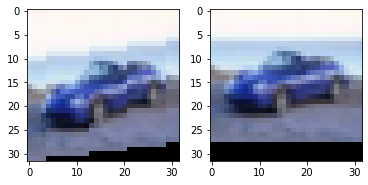

In [171]:
show((pool_img[0],global_img[0]))

Normalisierung umgekehrt

In [150]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],std = [ 1., 1., 1. ]),
                               ])

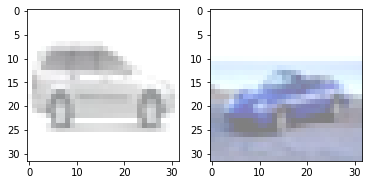

In [167]:
show((invTrans(pool_img[0]),invTrans(global_img[0])))

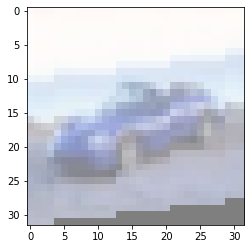

In [172]:
plt.imshow(invTrans(pool_img[0]).permute(1, 2, 0).numpy())

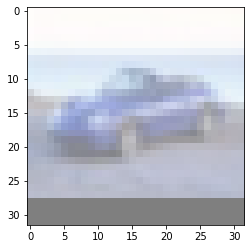

In [173]:
plt.imshow(invTrans(global_img[0]).permute(1, 2, 0).numpy())

In [174]:
torch.eq(invTrans(pool_img[0]),invTrans(global_img[0]))

tensor([[[ True, False, False,  ...,  True,  True,  True],
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]],

        [[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False,  True,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]],

        [[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False,  True,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [

In [33]:
torch.abs(invTrans(pool_img[0]) - invTrans(global_img[0]))

tensor([[[0.0000, 0.0118, 0.0157,  ..., 0.0275, 0.0275, 0.0078],
         [0.0078, 0.0157, 0.0157,  ..., 0.0275, 0.0157, 0.0039],
         [0.0118, 0.0196, 0.0196,  ..., 0.0275, 0.0078, 0.0000],
         ...,
         [0.0000, 0.0039, 0.0118,  ..., 0.0314, 0.0196, 0.0235],
         [0.0039, 0.0235, 0.0000,  ..., 0.0196, 0.0157, 0.0235],
         [0.0157, 0.0118, 0.0039,  ..., 0.0196, 0.0196, 0.0235]],

        [[0.0000, 0.0039, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
         [0.0000, 0.0039, 0.0039,  ..., 0.0039, 0.0275, 0.0000],
         [0.0039, 0.0000, 0.0039,  ..., 0.0039, 0.0275, 0.0000],
         ...,
         [0.0039, 0.0118, 0.0078,  ..., 0.0078, 0.0078, 0.0039],
         [0.0039, 0.0157, 0.0039,  ..., 0.0000, 0.0078, 0.0039],
         [0.0039, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0118, 0.0235, 0.0235,  ..., 0.0471, 0.0431, 0.0157],
         [0.0196, 0.0118, 0.0196,  ..., 0.0353, 0.0510, 0.0118],
         [0.0235, 0.0157, 0.0235,  ..., 0.0353, 0.0431, 0.

Versuche herauszufinden was folgende Zeile genau macht und wieso aber bisher erfolglos

In [ ]:
to_label_two = indices[np.array(to_label)]
to_label_two

array([118461,  71035, 134666, ..., 125054, 121123,  90797])

In [ ]:
print(type(to_label))
print(type(to_label_two))
print(len(to_label))
print(len(to_label_two))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
147000
147000


In [ ]:
indices[np.array(to_label)]

array([118461,  71035, 134666, ..., 125054, 121123,  90797])

In [ ]:
t = np.array([3,7,1,4])
t

array([3, 7, 1, 4])